In [31]:
# from transformers import Trainer, TrainingArguments
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
import torch
import numpy as np
import json
device = 'cpu'

In [32]:
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

In [50]:
path = "../data/yelp_academic_dataset_review.json"
review_fields_wanted = ['text','lowstar']
lowstar_review_limit = 512
review_limit = np.inf
rev = pd.DataFrame(columns=review_fields_wanted)
sample_per_cat = 512
max_num_words = 100
with open(path,encoding='utf-8') as d:
    counter = 0
    lowstar_counter = 0
    for line in d:
        L = json.loads(line)
        lowstar = L['stars'] == 1 or (L['stars'] == 2)
        fivestar = L['stars'] == 5
        not1or5 = not(lowstar or fivestar)
        if len(L['text'].split()) > max_num_words or not1or5:
            continue
        if lowstar:
            lowstar_counter += 1
            L['lowstar'] = 1
        else:
            L['lowstar'] = 0
        less_fields = {key: L[key] for key in review_fields_wanted }
        rev.loc[counter] = less_fields
        counter += 1
        if counter == review_limit or lowstar_counter == lowstar_review_limit:
            break

            
rev = rev.rename(columns = {'text':'_text','lowstar':'_lowstar'})


rev = rev.groupby('_lowstar').apply(lambda x: x.sample(sample_per_cat)).reset_index(drop=True)
rev['TARGETS'] = rev['_lowstar']

In [51]:

class DFToTokenized(Dataset):
    def __init__(self,df,tokenizer,max_len):
        self.len = len(df)
        self.data = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self,index):

        review = ' '.join(self.data['_text'][index].split())
        inp = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        tokens = inp['input_ids']
        mask = inp['attention_mask']

        return {
            'ids': torch.tensor(tokens, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.TARGETS[index], dtype=torch.uint8)
        } 

    def __len__(self):
        return self.len
        



In [52]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

train_frac = 0.8
train_dataset=rev.sample(frac=train_frac,random_state=200)
test_dataset=rev.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

training_set = DFToTokenized(train_dataset, tokenizer, MAX_LEN)
testing_set = DFToTokenized(test_dataset, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [53]:
class DBertMultiCat(torch.nn.Module):
    def __init__(self):
        super(DBertMultiCat, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [54]:
model = DBertMultiCat()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.uint8)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [56]:
for epoch in range(EPOCHS):
    train(epoch)

/home/pd/NNBasics/venv_NNBasics/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.6548776626586914
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 0: 51.03785103785104
Training Loss Epoch: 0.6941174492603395
Training Accuracy Epoch: 51.03785103785104
Training Loss per 5000 steps: 0.647396445274353
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 1: 58.36385836385836
Training Loss Epoch: 0.6691758235780204
Training Accuracy Epoch: 58.36385836385836
Training Loss per 5000 steps: 0.34756776690483093
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 2: 72.16117216117216
Training Loss Epoch: 0.5533422860430508
Training Accuracy Epoch: 72.16117216117216
Training Loss per 5000 steps: 0.2823229432106018
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 3: 88.52258852258852
Training Loss Epoch: 0.2982731263811995
Training Accuracy Epoch: 88.52258852258852
Training Loss per 5000 steps: 0.07740709185600281
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for E

In [79]:
def valid(model, testing_loader):
    tr_loss = 0 #added
    nb_tr_steps = 0 #added
    nb_tr_examples = 0 #added
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask)#.squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

In [80]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

/home/pd/NNBasics/venv_NNBasics/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Validation Loss per 100 steps: 1.702040433883667
Validation Accuracy per 100 steps: 50.0
Validation Loss Epoch: 0.5698703263492947
Validation Accuracy Epoch: 82.4390243902439
Accuracy on test data = 82.44%


In [68]:
a = next(iter(testing_loader))

In [18]:
a = torch.Tensor([1,2,3])
b = torch.Tensor([1,2])
a*b

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 0

In [73]:
b = next(iter(training_loader))

/home/pd/NNBasics/venv_NNBasics/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [74]:
b['targets']

tensor([0, 0, 0, 1], dtype=torch.uint8)

In [77]:
model(a['ids'],a['mask']).squeeze()

tensor([[ 2.5051, -2.8024],
        [-2.4012,  2.8688]], grad_fn=<SqueezeBackward0>)

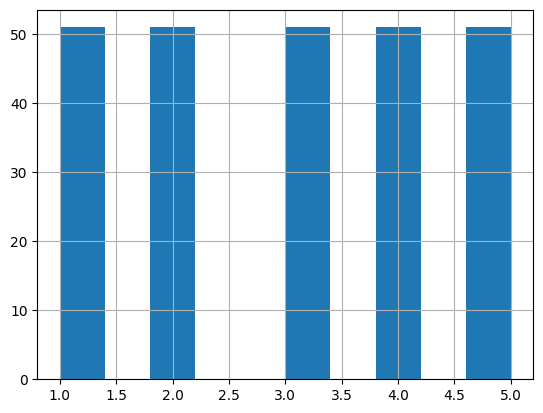

In [ ]:
df1 = rev['_stars'].hist()

In [76]:
output_model_file = '../models/yelp_sentiment.bin'
output_vocab_file = '../models/yelp_sentiment_vocab.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

('../models/yelp_sentiment_vocab.bin',)

In [45]:
rev.head()

,_text,_lowstar,TARGETS
0,I live in the neighborhood so I try to frequen...,0,{'High': 0}
1,I love this place. Been three times for their ...,0,{'High': 0}
2,Visited Shaving Grace on Friday for a hair cut...,0,{'High': 0}
3,It was very good! All the meats (particular t...,0,{'High': 0}
4,Wow. We visited NOLA last week and took the tr...,0,{'High': 0}


In [ ]:
dfs = rev.groupby('_stars').apply(lambda x: x.sample(5))

<AxesSubplot: >

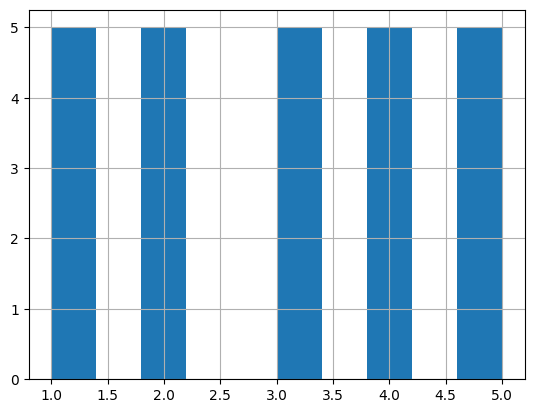

In [ ]:
dfs['_stars'].hist()

<AxesSubplot: >

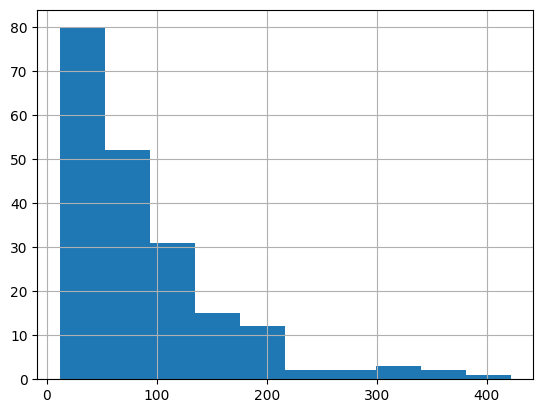

In [ ]:
a = rev['_text'].apply(lambda x: len(x.split()))
a.hist()

In [ ]:
    with open('/home/pd/NNBasics/NNBasics/notebooks/out2.txt','w') as f:
        f.write(str(index)+'\n')

NameError: name 'index' is not defined

In [ ]:
' '.join(rev['_text'].split())

"With winter weather in full effect, a good cup of tea really soothes the body and mind. I'm usually a coffee guy but every once in a while you go to work feeling sick, but not deathly ill so you know you should still go to work, go here. Their potent brews will dull the searing pain in your throat and keep the snot at bay. Their wide selection of teas and tea-related beverages can make your head spin so ask the pros behind the counter, or you can just reference the clever names for guidance. Free wifi and a healthy selection of books; typically very quiet as well."